<a href="https://colab.research.google.com/github/knxghtly/python-tensorflow-MLDL-Study/blob/main/%5B7%5D%EC%9D%B8%EA%B3%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. 데이터 준비

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
교차 검증 점수 평균: 0.8437333333333334


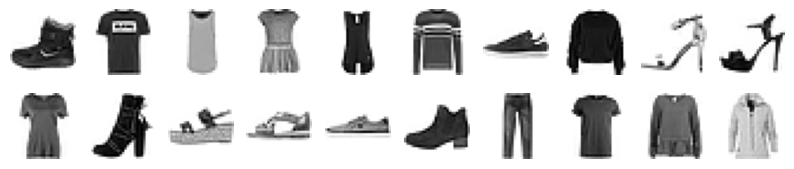

train_target: [9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]
클래스개수 & 샘플개수: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

(train_input, train_target), (val_input, val_target) = keras.datasets.fashion_mnist.load_data()

# 0-1 값으로 맞추고 sample 하나를 1차원으로
train_scaled = (train_input / 255.0).reshape(-1, 28*28)
val_scaled = (val_input / 255.0).reshape(-1, 28*28)

from sklearn.linear_model import SGDClassifier # SGD분류모델
from sklearn.model_selection import cross_validate # 교차 검증
sc = SGDClassifier(loss="log_loss", max_iter=20, random_state=42)
scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1)
print("교차 검증 점수 평균:", np.mean(scores['test_score']))

# 서브플롯(2,10) 생성
fig, axs = plt.subplots(2, 10, figsize=(10, 2))
for i in range(20):
  axs[i//10][i%10].imshow(train_input[i], cmap="gray_r")
  axs[i//10][i%10].axis("off") # 축 표시 off
plt.show()
print("train_target:", train_target[:20])
print("클래스개수 & 샘플개수:", np.unique(train_target, return_counts=True))

#keras.Sequential로 간단한 인공신경망 만들기

In [ ]:
# keras.backend.clear_session() # 캐싱 문제 발생 시
print(train_scaled.shape)
print(train_target.shape)
print(val_scaled.shape)
print(val_target.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


# Keras `Sequential` 모델 사용법

Keras의 `Sequential` 모델은 층을 순차적으로 쌓아서 신경망을 구성하는 방법입니다. 각 층을 차례로 추가하여 모델을 정의합니다. 아래에서는 각 층의 역할과 설정 방법을 자세히 설명합니다.

---

## 1. 모델 생성
  ```python
  model = keras.Sequential([ 층 ], name="myModel")
  ```
---
## 2. 층 추가 & 정의

###입력층 (Input, Flatten)
  ```python
  model.add(keras.layers.Input(shape=(784,))) # 입력 크기 지정
  model.add(keras.layers.Flatten(input_shape=(28, 28))) # 2d -> 1d
  ```

###은닉층

은닉층은 모델의 중간 처리 단계로, 다양한 활성화 함수와 뉴런 수를 지정

  ```python
  model.add(keras.layers.Dense(100, activation="relu", name="hidden_layer"))
  ```
  - 100개의 뉴런
  - activation(활성화함수)
    - "relu": 비선형 활성화 함수 (주로 사용)
    - "sigmoid": 이진 분류에서 사용
    - "softmax": 다중 클래스 분류에서 사용

###드롭아웃

```python
model.add(keras.layers.Dropout( 0.3 ))
```

- epochs가 늘어날수록 과대적합되는 경향을 막고자 드롭아웃을 도입
- 각 샘플을 계산할 때마다, 은닉층의 뉴런을 일정 비율 끄므로써 훈련세트에 과대적합을 막음

###출력층
```python
model.add(keras.layers.Dense(10, activation="softmax", name="output"))
```
- 10개의 뉴런
- **출력층 뉴런 개수 (units)**는 분류할 클래스의 개수에 맞춰 설정
- **활성화 함수 (activation)**
    - "sigmoid": 이진 분류에서 사용
    - "softmax": 다중 클래스 분류에서 사용
---

In [ ]:
model = keras.Sequential(name="myModel")
model.add(keras.layers.Input(shape=(784,)))
model.add(keras.layers.Dense(100, activation="relu", name="hidden"))
model.add(keras.layers.Dense(10, activation="softmax", name="output"))


---
##3. 모델 설정( **model.compile( )** )
1. **loss (손실 함수)**: 예측값과 실제값 사이의 오차를 계산하는 함수

  - **binary_crossentropy**: 이진 분류 시

  - **categorical_crossentropy**:	다중 분류 + 원-핫 인코딩 (one-hot)
  
    (예: [0, 1, 0, ...])
  
  - **sparse_categorical_crossentropy**:  정수 인코딩 (integer labels)

    (예: 0, 1, 2, ... 9)

2. **metrics**=["평가 지표"]: loss와 함께 출력될 지표 지정 (list)

  - **accuracy**(정확도): (TP+TN)/(TP+TN+FP+FN) ​전체 샘플 중 맞춘 비율
  - **precision**(정밀도): TP/(TP+FP) 양성이라고 예측한(TP+FP) 것 중에서 실제 양성 비율
  - **recall**(재현율): TP/(TP+FN) 실제 양성(TP+FN) 중에서 양성이라고 예측한 비율
  - **"precision", "recall" 은 target이 원-핫 인코딩되어야 함**

3. **optimizer**= "최적화 함수"

| **Optimizer** | **설명** | **주요 특징** | **학습률(learning_rate) 기본값** |
|--------------|--------|-------------|----------------------------|
| **"sgd"** | 확률적 경사 하강법 (Stochastic Gradient Descent) | - 기본적인 경사 하강법 <br> - 단순하지만 학습 속도가 느림 | 0.01 |
| **SGD(momentum=0.9)** | 모멘텀을 적용한 SGD | - 이전 이동 방향을 고려해 진동을 줄이고 속도를 증가 | 0.01 |
| **"adagrad"** | Adagrad (Adaptive Gradient) | - 가중치별로 다른 학습률 적용 <br> - 학습률이 계속 감소하여 장기 학습에 불리 | 0.001 |
| **"rmsprop"** | RMSprop (Root Mean Square Propagation) | - Adagrad의 단점 보완 <br> - 가중치별 학습률 조정 + 지수 가중 이동 평균 적용 | 0.001 |
| **"adam"** | Adam (Adaptive Moment Estimation) | - `Momentum` + `RMSprop` 조합 <br> - 대부분의 문제에서 기본값으로 사용 | 0.001 |
| **"adamax"** | Adam의 변형 (무한 노름 사용) | - Adam보다 안정적일 수 있음 | 0.002 |
| **"nadam"** | Adam + NAG (Nesterov Accelerated Gradient) | - Adam에 NAG 적용, 더 빠르게 수렴 가능 | 0.002 |

### **사용 예시**
```python
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
```
---

In [ ]:
# one-hot encoding
train_target_one_hot = keras.utils.to_categorical(train_target, num_classes=10)
val_target_one_hot = keras.utils.to_categorical(val_target, num_classes=10)

# 모델 설정(.compile)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

##4. 모델 구조 확인

  1.  **model.summary()**

    - **param**개수: 이전층출력 * 현재층뉴런개수 + 현재층뉴런개수
  
  2.**keras.utils.plot_model(model, show_shapes=True)**

    - show_shapes=True: 각 층의 Input shape도 볼 수 있음
---

In [ ]:
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "myModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hidden (Dense)                       │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

---
##5. callback 함수들 ( keras.callbacks 라이브러리 )

1. **ModelCheckPoint**: 가장 낮은 손실값일 때 가중치 저장
  -
```python
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-model.keras")
```

2. **EarlyStopping**: 조기 종료( patience, restore_best_weights )
  - patience = 3 : val_loss값 연속 상승을 참는 매개변수
  - restore_best_weights=True : 학습종료 후 가중치 복귀
  - ```python
    early_stopping_cb = keras.callbacks.EarlyStopping(
      patience=2,restore_best_weights=True)

    # print(early_stopping_cb.stopped_epoch)
    ```
---

In [ ]:
# callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-cnn-model.keras")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

---
##6. 모델 학습

1. **model.fit(train_scaled, train_target_one_hot)**
  - **epochs**=5
  - **verbose**=0 / 1 / 2
  - **validation_data**=( val_scaled, val_target_one_hot )
  - **callbacks**=[ callback함수 리스트 ]
---
##7. 모델 평가( **model.evaluate(train_scaled, train_target)** )
---

In [ ]:
# model 학습
history = model.fit(train_scaled, train_target_one_hot,
                    epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target_one_hot),
                    callbacks=[checkpoint_cb, early_stopping_cb])

# model 평가
model.evaluate(val_scaled, val_target_one_hot)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8841 - loss: 0.3360


[0.3339552879333496, 0.8838000297546387]

##돌아보기

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


<ipython-input-12-0a6ab11d61a8>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


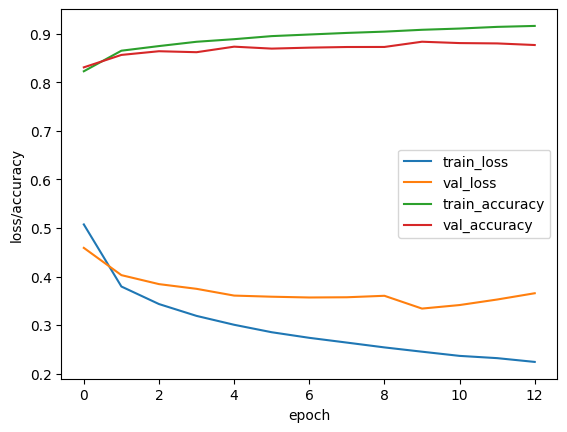

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("loss/accuracy")
plt.legend()
plt.legend(["train_loss", "val_loss", "train_accuracy", "val_accuracy"])
plt.show()

# 모델 저장과 복원

```python
#가중치만 저장/복원
model.save_weights("model-weights.keras")
model.load_weights("model-weights.keras")
#모델 전체 저장/복원
model.save("model-whole.keras")
model.load("model-whole.keras")
#테스트코드
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))
# 0.875166666666
```